# Importamos librerías

In [20]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos/Campo 50 puntos'

## Datos de entrenamiento

### Datos

In [5]:
campvectrain = np.load(path + '/campvectrain.npy')

In [6]:
np.shape(campvectrain)

(7000, 2, 50, 50)

### Coeficientes

In [7]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [8]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
campvectest = np.load(path + '/campvectest.npy')

In [10]:
np.shape(campvectest)

(2000, 2, 50, 50)

### Coeficientes

In [11]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [12]:
np.shape(coefcampvectest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
campvecval = np.load(path + '/campvecval.npy')

In [14]:
np.shape(campvecval)

(1000, 2, 50, 50)

### Coeficienes

In [15]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [16]:
np.shape(coefcampvecval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(2, 50, 50), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [21]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(2,50,50)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(50, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(50, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(25, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(12, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation = custom_activation)
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 batch_normalization (BatchN  (None, 5000)             20000     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 50)                250050    
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 12)                312       
                                                        

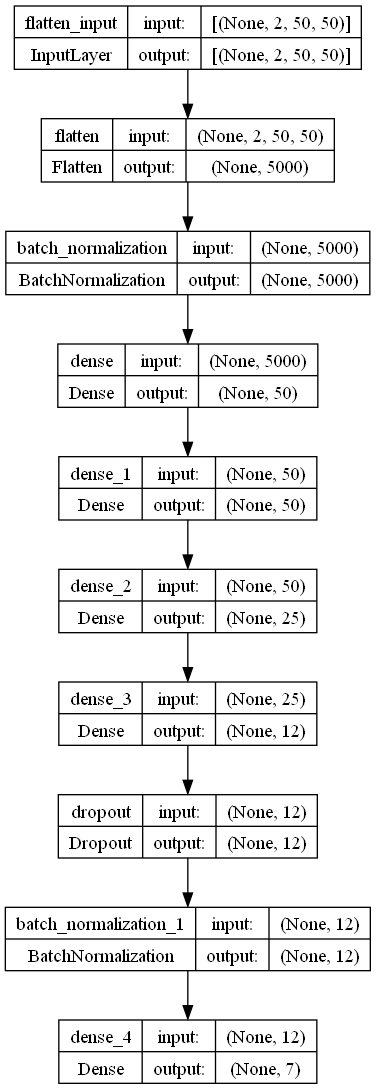

In [24]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [25]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [26]:
model.compile(optimizer=optimizer,
              loss= 'MSE',
              metrics=['mae'])

In [27]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [28]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
700/700 [==============================] - 2s 2ms/step - loss: 11.5098 - mae: 2.2354 - val_loss: 8.0966 - val_mae: 1.8620 - lr: 0.0010
Epoch 2/1000
700/700 [==============================] - 1s 2ms/step - loss: 8.3361 - mae: 2.0360 - val_loss: 7.0670 - val_mae: 1.8547 - lr: 0.0010
Epoch 3/1000
700/700 [==============================] - 1s 2ms/step - loss: 7.7208 - mae: 1.9888 - val_loss: 6.7016 - val_mae: 1.7839 - lr: 0.0010
Epoch 4/1000
700/700 [==============================] - 1s 2ms/step - loss: 7.2652 - mae: 1.9135 - val_loss: 6.2456 - val_mae: 1.7110 - lr: 0.0010
Epoch 5/1000
700/700 [==============================] - 1s 2ms/step - loss: 7.1690 - mae: 1.8905 - val_loss: 6.1168 - val_mae: 1.6880 - lr: 0.0010
Epoch 6/1000
700/700 [==============================] - 1s 2ms/step - loss: 6.8453 - mae: 1.8665 - val_loss: 5.5761 - val_mae: 1.6228 - lr: 0.0010
Epoch 7/1000
700/700 [==============================] - 1s 2ms/step - loss: 6.6430 - mae: 1.8218 - val_loss: 5.0054 -

700/700 [==============================] - 1s 2ms/step - loss: 4.2557 - mae: 1.5717 - val_loss: 2.7831 - val_mae: 1.1265 - lr: 0.0010
Epoch 57/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.2897 - mae: 1.5746 - val_loss: 2.7944 - val_mae: 1.1578 - lr: 0.0010
Epoch 58/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.2758 - mae: 1.5750 - val_loss: 2.7028 - val_mae: 1.1070 - lr: 0.0010
Epoch 59/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.2717 - mae: 1.5741 - val_loss: 2.7020 - val_mae: 1.1030 - lr: 0.0010
Epoch 60/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.2260 - mae: 1.5617 - val_loss: 2.7158 - val_mae: 1.1099 - lr: 0.0010
Epoch 61/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.2641 - mae: 1.5687 - val_loss: 2.8018 - val_mae: 1.1778 - lr: 0.0010
Epoch 62/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.2310 - mae: 1.5655 - val_loss: 2.7980 - val_mae

700/700 [==============================] - 1s 2ms/step - loss: 4.1169 - mae: 1.5354 - val_loss: 2.7172 - val_mae: 1.1140 - lr: 0.0010
Epoch 112/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0972 - mae: 1.5298 - val_loss: 2.6175 - val_mae: 1.0720 - lr: 0.0010
Epoch 113/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.1416 - mae: 1.5435 - val_loss: 2.7440 - val_mae: 1.1297 - lr: 0.0010
Epoch 114/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.1320 - mae: 1.5418 - val_loss: 2.5141 - val_mae: 0.9959 - lr: 0.0010
Epoch 115/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.1002 - mae: 1.5338 - val_loss: 2.5797 - val_mae: 1.0490 - lr: 0.0010
Epoch 116/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.1076 - mae: 1.5344 - val_loss: 2.6520 - val_mae: 1.0752 - lr: 0.0010
Epoch 117/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.1250 - mae: 1.5413 - val_loss: 2.8384 - v

700/700 [==============================] - 1s 2ms/step - loss: 4.1056 - mae: 1.5322 - val_loss: 2.6527 - val_mae: 1.0695 - lr: 0.0010
Epoch 167/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0674 - mae: 1.5256 - val_loss: 2.5815 - val_mae: 1.0349 - lr: 0.0010
Epoch 168/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.1006 - mae: 1.5303 - val_loss: 2.6126 - val_mae: 1.0565 - lr: 0.0010
Epoch 169/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.1082 - mae: 1.5341 - val_loss: 2.7258 - val_mae: 1.1287 - lr: 0.0010
Epoch 170/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.1191 - mae: 1.5342 - val_loss: 2.6532 - val_mae: 1.0860 - lr: 0.0010
Epoch 171/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0892 - mae: 1.5289 - val_loss: 2.5744 - val_mae: 1.0381 - lr: 0.0010
Epoch 172/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0949 - mae: 1.5293 - val_loss: 2.5590 - v

700/700 [==============================] - 1s 2ms/step - loss: 4.1081 - mae: 1.5314 - val_loss: 2.6631 - val_mae: 1.0708 - lr: 0.0010
Epoch 222/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0491 - mae: 1.5192 - val_loss: 2.6430 - val_mae: 1.0823 - lr: 0.0010
Epoch 223/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0917 - mae: 1.5331 - val_loss: 2.5677 - val_mae: 1.0254 - lr: 0.0010
Epoch 224/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0916 - mae: 1.5280 - val_loss: 2.6714 - val_mae: 1.1232 - lr: 0.0010
Epoch 225/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0955 - mae: 1.5276 - val_loss: 2.8436 - val_mae: 1.1738 - lr: 0.0010
Epoch 226/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0860 - mae: 1.5271 - val_loss: 2.5710 - val_mae: 1.0702 - lr: 0.0010
Epoch 227/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0879 - mae: 1.5302 - val_loss: 2.8856 - v

700/700 [==============================] - 1s 2ms/step - loss: 4.0779 - mae: 1.5284 - val_loss: 2.7347 - val_mae: 1.1253 - lr: 0.0010
Epoch 277/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0492 - mae: 1.5226 - val_loss: 2.6548 - val_mae: 1.0685 - lr: 0.0010
Epoch 278/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0992 - mae: 1.5311 - val_loss: 2.6315 - val_mae: 1.0940 - lr: 0.0010
Epoch 279/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0661 - mae: 1.5201 - val_loss: 2.6255 - val_mae: 1.0802 - lr: 0.0010
Epoch 280/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0661 - mae: 1.5195 - val_loss: 2.5350 - val_mae: 1.0391 - lr: 0.0010
Epoch 281/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0647 - mae: 1.5223 - val_loss: 2.6261 - val_mae: 1.0795 - lr: 0.0010
Epoch 282/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0616 - mae: 1.5237 - val_loss: 2.7704 - v

700/700 [==============================] - 1s 2ms/step - loss: 4.0676 - mae: 1.5220 - val_loss: 2.5804 - val_mae: 1.0421 - lr: 0.0010
Epoch 332/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0646 - mae: 1.5218 - val_loss: 2.5278 - val_mae: 1.0187 - lr: 0.0010
Epoch 333/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0702 - mae: 1.5210 - val_loss: 2.5881 - val_mae: 1.0548 - lr: 0.0010
Epoch 334/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0274 - mae: 1.5141 - val_loss: 2.5867 - val_mae: 1.0826 - lr: 0.0010
Epoch 335/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0314 - mae: 1.5146 - val_loss: 2.6517 - val_mae: 1.0864 - lr: 0.0010
Epoch 336/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0588 - mae: 1.5238 - val_loss: 2.5025 - val_mae: 1.0134 - lr: 0.0010
Epoch 337/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0408 - mae: 1.5140 - val_loss: 2.7443 - v

700/700 [==============================] - 1s 2ms/step - loss: 4.0399 - mae: 1.5138 - val_loss: 2.5044 - val_mae: 1.0152 - lr: 0.0010
Epoch 387/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0141 - mae: 1.5109 - val_loss: 2.5831 - val_mae: 1.0523 - lr: 0.0010
Epoch 388/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0456 - mae: 1.5161 - val_loss: 2.6694 - val_mae: 1.1008 - lr: 0.0010
Epoch 389/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0863 - mae: 1.5239 - val_loss: 2.6381 - val_mae: 1.1002 - lr: 0.0010
Epoch 390/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0816 - mae: 1.5244 - val_loss: 2.6506 - val_mae: 1.0935 - lr: 0.0010
Epoch 391/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0553 - mae: 1.5179 - val_loss: 2.7214 - val_mae: 1.1293 - lr: 0.0010
Epoch 392/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0486 - mae: 1.5187 - val_loss: 2.7896 - v

700/700 [==============================] - 1s 2ms/step - loss: 4.0710 - mae: 1.5240 - val_loss: 2.7309 - val_mae: 1.1343 - lr: 9.3565e-04
Epoch 441/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0466 - mae: 1.5170 - val_loss: 2.5377 - val_mae: 1.0319 - lr: 9.3400e-04
Epoch 442/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0246 - mae: 1.5113 - val_loss: 2.6303 - val_mae: 1.0970 - lr: 9.3235e-04
Epoch 443/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0421 - mae: 1.5158 - val_loss: 2.5581 - val_mae: 1.0283 - lr: 9.3070e-04
Epoch 444/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0643 - mae: 1.5199 - val_loss: 2.5531 - val_mae: 1.0238 - lr: 9.2905e-04
Epoch 445/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0276 - mae: 1.5118 - val_loss: 2.5638 - val_mae: 1.0467 - lr: 9.2740e-04
Epoch 446/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0506 - mae: 1.524

Epoch 494/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0114 - mae: 1.5090 - val_loss: 2.5295 - val_mae: 1.0368 - lr: 8.4655e-04
Epoch 495/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0460 - mae: 1.5232 - val_loss: 2.7513 - val_mae: 1.1662 - lr: 8.4490e-04
Epoch 496/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0168 - mae: 1.5112 - val_loss: 2.6244 - val_mae: 1.0756 - lr: 8.4325e-04
Epoch 497/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0110 - mae: 1.5146 - val_loss: 2.4981 - val_mae: 1.0048 - lr: 8.4160e-04
Epoch 498/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0434 - mae: 1.5174 - val_loss: 2.7120 - val_mae: 1.1418 - lr: 8.3995e-04
Epoch 499/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0119 - mae: 1.5089 - val_loss: 2.6350 - val_mae: 1.1071 - lr: 8.3830e-04
Epoch 500/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.01

700/700 [==============================] - 1s 2ms/step - loss: 4.0482 - mae: 1.5223 - val_loss: 2.5281 - val_mae: 1.0581 - lr: 7.5910e-04
Epoch 548/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9788 - mae: 1.5030 - val_loss: 2.5945 - val_mae: 1.1036 - lr: 7.5745e-04
Epoch 549/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0150 - mae: 1.5104 - val_loss: 2.4671 - val_mae: 0.9852 - lr: 7.5580e-04
Epoch 550/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9909 - mae: 1.5074 - val_loss: 2.4977 - val_mae: 1.0073 - lr: 7.5415e-04
Epoch 551/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9772 - mae: 1.5053 - val_loss: 2.5457 - val_mae: 1.0575 - lr: 7.5250e-04
Epoch 552/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9600 - mae: 1.4994 - val_loss: 2.5303 - val_mae: 1.0425 - lr: 7.5085e-04
Epoch 553/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0568 - mae: 1.522

Epoch 601/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9699 - mae: 1.5024 - val_loss: 2.7174 - val_mae: 1.1532 - lr: 6.7000e-04
Epoch 602/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9619 - mae: 1.4965 - val_loss: 2.4895 - val_mae: 1.0013 - lr: 6.6835e-04
Epoch 603/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9853 - mae: 1.5058 - val_loss: 2.6403 - val_mae: 1.1231 - lr: 6.6670e-04
Epoch 604/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9638 - mae: 1.5012 - val_loss: 2.5727 - val_mae: 1.0548 - lr: 6.6505e-04
Epoch 605/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9570 - mae: 1.4983 - val_loss: 2.4686 - val_mae: 1.0055 - lr: 6.6340e-04
Epoch 606/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9738 - mae: 1.5080 - val_loss: 2.4863 - val_mae: 0.9998 - lr: 6.6175e-04
Epoch 607/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.98

700/700 [==============================] - 1s 2ms/step - loss: 3.9336 - mae: 1.4976 - val_loss: 2.4709 - val_mae: 1.0050 - lr: 5.8255e-04
Epoch 655/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9584 - mae: 1.5025 - val_loss: 2.4846 - val_mae: 1.0122 - lr: 5.8090e-04
Epoch 656/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9602 - mae: 1.5006 - val_loss: 2.4524 - val_mae: 0.9919 - lr: 5.7925e-04
Epoch 657/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9595 - mae: 1.5003 - val_loss: 2.5066 - val_mae: 1.0384 - lr: 5.7760e-04
Epoch 658/1000
700/700 [==============================] - 1s 2ms/step - loss: 4.0320 - mae: 1.5162 - val_loss: 2.4535 - val_mae: 1.0061 - lr: 5.7595e-04
Epoch 659/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9403 - mae: 1.4953 - val_loss: 2.4176 - val_mae: 0.9804 - lr: 5.7430e-04
Epoch 660/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9687 - mae: 1.502

Epoch 708/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9279 - mae: 1.4960 - val_loss: 2.4159 - val_mae: 0.9619 - lr: 4.9345e-04
Epoch 709/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9566 - mae: 1.4991 - val_loss: 2.4063 - val_mae: 0.9793 - lr: 4.9180e-04
Epoch 710/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9410 - mae: 1.4998 - val_loss: 2.4921 - val_mae: 1.0345 - lr: 4.9015e-04
Epoch 711/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9122 - mae: 1.4938 - val_loss: 2.5316 - val_mae: 1.0683 - lr: 4.8850e-04
Epoch 712/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9328 - mae: 1.4969 - val_loss: 2.4463 - val_mae: 0.9922 - lr: 4.8685e-04
Epoch 713/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9383 - mae: 1.4966 - val_loss: 2.4556 - val_mae: 0.9933 - lr: 4.8520e-04
Epoch 714/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.94

700/700 [==============================] - 1s 2ms/step - loss: 3.9371 - mae: 1.4988 - val_loss: 2.4058 - val_mae: 0.9714 - lr: 4.0600e-04
Epoch 762/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9063 - mae: 1.4892 - val_loss: 2.4452 - val_mae: 0.9828 - lr: 4.0435e-04
Epoch 763/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9053 - mae: 1.4897 - val_loss: 2.4790 - val_mae: 1.0341 - lr: 4.0270e-04
Epoch 764/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9467 - mae: 1.4994 - val_loss: 2.4250 - val_mae: 0.9918 - lr: 4.0105e-04
Epoch 765/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9263 - mae: 1.4955 - val_loss: 2.4149 - val_mae: 0.9799 - lr: 3.9940e-04
Epoch 766/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9159 - mae: 1.4918 - val_loss: 2.4113 - val_mae: 0.9751 - lr: 3.9775e-04
Epoch 767/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9245 - mae: 1.495

Epoch 815/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.8711 - mae: 1.4823 - val_loss: 2.3882 - val_mae: 0.9537 - lr: 3.1690e-04
Epoch 816/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9099 - mae: 1.4887 - val_loss: 2.4387 - val_mae: 1.0067 - lr: 3.1525e-04
Epoch 817/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9245 - mae: 1.4951 - val_loss: 2.3912 - val_mae: 0.9743 - lr: 3.1360e-04
Epoch 818/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.8785 - mae: 1.4818 - val_loss: 2.4263 - val_mae: 0.9996 - lr: 3.1195e-04
Epoch 819/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9491 - mae: 1.4995 - val_loss: 2.4001 - val_mae: 0.9723 - lr: 3.1030e-04
Epoch 820/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.8968 - mae: 1.4888 - val_loss: 2.4126 - val_mae: 0.9855 - lr: 3.0865e-04
Epoch 821/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.90

700/700 [==============================] - 1s 2ms/step - loss: 3.8970 - mae: 1.4891 - val_loss: 2.4211 - val_mae: 0.9971 - lr: 2.2945e-04
Epoch 869/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.8681 - mae: 1.4818 - val_loss: 2.3833 - val_mae: 0.9624 - lr: 2.2780e-04
Epoch 870/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9153 - mae: 1.4934 - val_loss: 2.4973 - val_mae: 1.0540 - lr: 2.2615e-04
Epoch 871/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.8947 - mae: 1.4917 - val_loss: 2.3944 - val_mae: 0.9688 - lr: 2.2450e-04
Epoch 872/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9007 - mae: 1.4893 - val_loss: 2.3912 - val_mae: 0.9638 - lr: 2.2285e-04
Epoch 873/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.8812 - mae: 1.4855 - val_loss: 2.4065 - val_mae: 0.9803 - lr: 2.2120e-04
Epoch 874/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.8853 - mae: 1.487

Epoch 922/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.9020 - mae: 1.4893 - val_loss: 2.3846 - val_mae: 0.9723 - lr: 1.4035e-04
Epoch 923/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.8751 - mae: 1.4851 - val_loss: 2.3722 - val_mae: 0.9641 - lr: 1.3870e-04
Epoch 924/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.8833 - mae: 1.4884 - val_loss: 2.3756 - val_mae: 0.9596 - lr: 1.3705e-04
Epoch 925/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.8710 - mae: 1.4836 - val_loss: 2.3615 - val_mae: 0.9487 - lr: 1.3540e-04
Epoch 926/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.8363 - mae: 1.4755 - val_loss: 2.3955 - val_mae: 0.9742 - lr: 1.3375e-04
Epoch 927/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.8653 - mae: 1.4836 - val_loss: 2.4144 - val_mae: 0.9913 - lr: 1.3210e-04
Epoch 928/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.86

700/700 [==============================] - 1s 2ms/step - loss: 3.8646 - mae: 1.4810 - val_loss: 2.3561 - val_mae: 0.9457 - lr: 5.2900e-05
Epoch 976/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.8651 - mae: 1.4822 - val_loss: 2.3643 - val_mae: 0.9540 - lr: 5.1250e-05
Epoch 977/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.8354 - mae: 1.4753 - val_loss: 2.3555 - val_mae: 0.9450 - lr: 4.9600e-05
Epoch 978/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.8859 - mae: 1.4888 - val_loss: 2.3684 - val_mae: 0.9598 - lr: 4.7950e-05
Epoch 979/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.8332 - mae: 1.4772 - val_loss: 2.3560 - val_mae: 0.9443 - lr: 4.6300e-05
Epoch 980/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.8682 - mae: 1.4841 - val_loss: 2.3630 - val_mae: 0.9537 - lr: 4.4650e-05
Epoch 981/1000
700/700 [==============================] - 1s 2ms/step - loss: 3.8541 - mae: 1.479

# Analizamos accuracy y loss

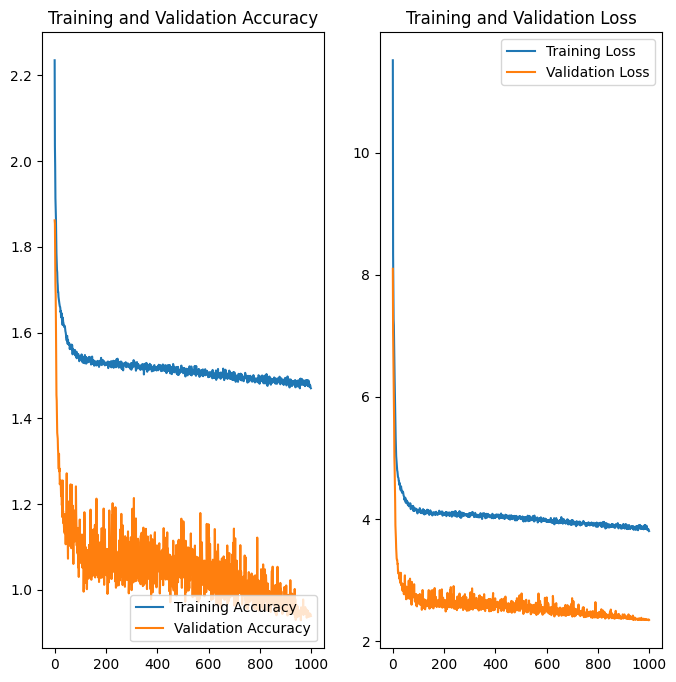

In [30]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluamos el modelo

In [31]:
test_loss, test_acc = model.evaluate(campvecval,coefcampvecval)

32/32 [==============================] - 0s 1ms/step - loss: 2.3470 - mae: 0.9391


In [32]:
predictions = model.predict(campvecval)

32/32 [==============================] - 0s 965us/step


In [33]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefcampvecval, predictions)

# Calcula la desviación estándar del error
error = coefcampvecval - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 0.9390958528856613, Desviación estándar del error: 1.5165621119405748, Error absoluto máximo: 6.252265930175781


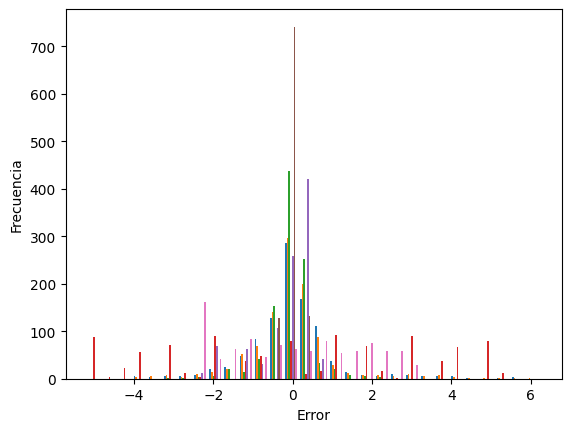

In [34]:
import matplotlib.pyplot as plt

plt.hist(error, bins=30)
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

In [35]:
from sklearn.metrics import r2_score

r2 = r2_score(coefcampvecval, predictions)
r2

0.6739986437716993

In [36]:
error_percentile_90 = np.percentile(np.abs(error), 90)
error_percentile_90

2.6655367851257377

# Guardamos los datos accuracy y loss

In [37]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 50,100/historycampvec50.csv', index=False)

# Guardamos el modelo

In [38]:
path_to_save = '../../../Modelos/Modelos 50,100'

In [39]:
model.save(path_to_save + '/campovectorial50.h5')

# Importamos el modelo

In [41]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [43]:
import keras
import tensorflow as tf
custom_objects = {'custom_activation': custom_activation}
new_model = keras.models.load_model('../../../Modelos/Modelos 50,100/campovectorial50.h5', custom_objects= custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [44]:
import random
from scipy.integrate import solve_ivp

campvec = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos =10

    y1 = np.linspace(x_range_neg, x_range_pos, 50)
    y2 = np.linspace(y_range_neg, y_range_pos, 50)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)

    
campvec = np.array(campvec)
coef = np.array(coef)


--------------------------------------------
[6, 4, 3, 6, 4, 9, 1]


In [45]:
campvecnone = campvec[None, :]

## Predecimos con los datos nuevos

In [46]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 50ms/step
[[5. 4. 3. 5. 4. 9. 2.]]


## Encontramos puntos de equilibrio datos reales

In [47]:
from scipy.optimize import fsolve
# Sistema de ecuaciones
def system(Y):
    X, Y = Y
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1
    return [dX_dt, dY_dt]

# Adivinanza inicial para X, Y
initial_guess = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_reales = fsolve(system, initial_guess)
primer_cuadrante_reales = tuple(primer_cuadrante_reales)


print(primer_cuadrante_reales)

(1.7535169457215285, 0.4947430697560692)


## Graficamos con los coeficientes reales

Text(0, 0.5, 'Concentración Y')

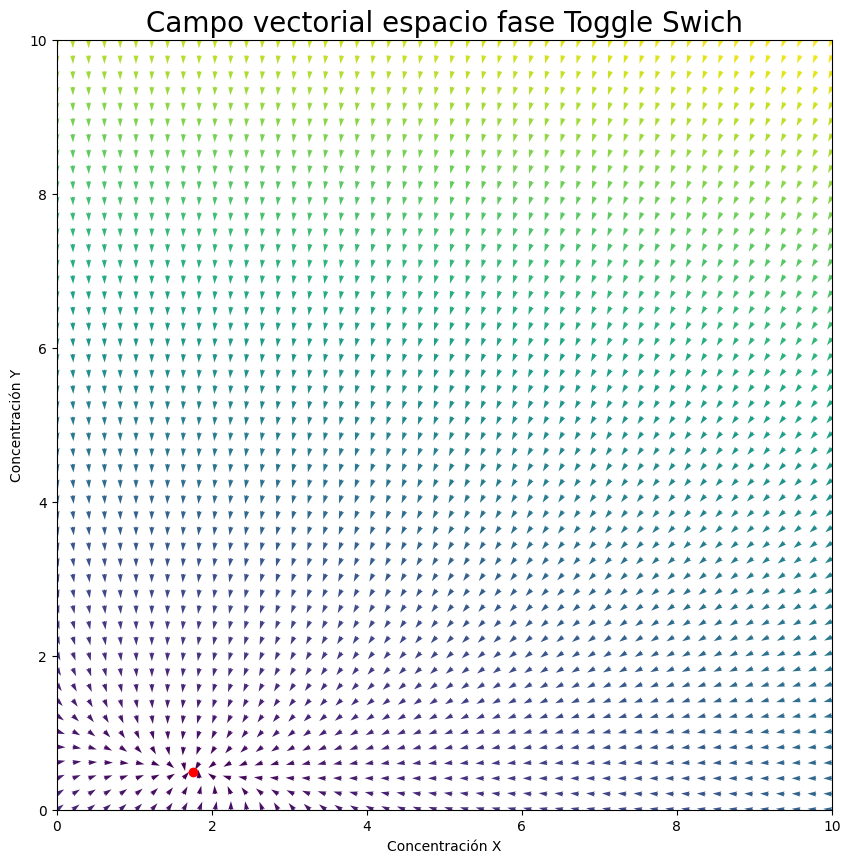

In [48]:
import matplotlib.pyplot as plt

x_values = primer_cuadrante_reales[0]
y_values =primer_cuadrante_reales[1]
y1 = np.linspace(0, 10, 50)
y2 = np.linspace(0, 10, 50)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.scatter(x_values, y_values, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Encontramos puntos de equilibro datos predecidos

In [49]:
a1pred = new_predictions[0,0]
a2pred = new_predictions[0,1]
b1pred = new_predictions[0,2]
b2pred = new_predictions[0,3]
d1pred = new_predictions[0,4]
d2pred = new_predictions[0,5]
npred = new_predictions[0,6]

def systempred(Ypred):
    Xpred, Ypred = Ypred
    dXpred_dt = a1pred/(1+Ypred**npred)-d1pred*Xpred+b1pred
    dYpred_dt = a2pred/(1+Xpred**npred)-d2pred*Ypred+b1pred
    return [dXpred_dt, dYpred_dt]

# Adivinanza inicial para X, Y
initial_guesspred = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_predecidos = fsolve(systempred, initial_guesspred)
primer_cuadrante_predecidos = tuple(primer_cuadrante_predecidos)


print(primer_cuadrante_predecidos)

(1.7985777054052547, 0.43828182295290885)


## Graficamos con los coeficientes predecidos

Text(0, 0.5, 'Concentración Y')

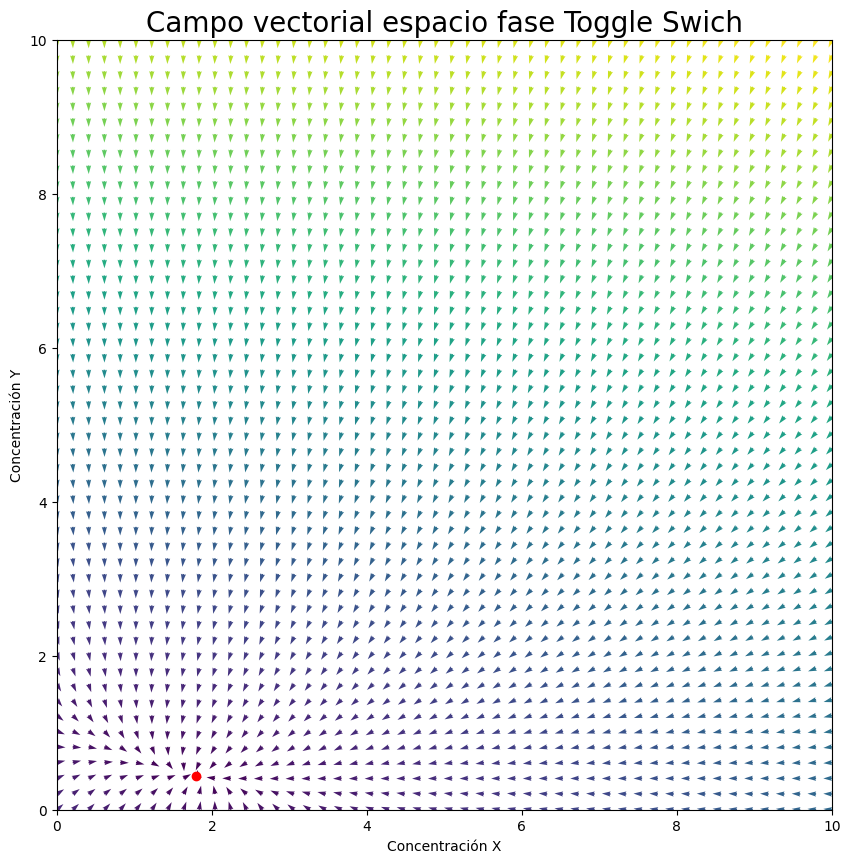

In [50]:
import matplotlib.pyplot as plt

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
    dY_dt = a2pred/(1+X**npred)-d2pred*Y+b1pred

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1pred = np.linspace(x_range_neg, x_range_pos, 50)
y2pred = np.linspace(y_range_neg, y_range_pos, 50)

Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
t1 = 0

upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)

NI, NJ = Y1.shape

u1pred, v1pred = f(t1, [Y1, Y2])
upred, vpred = f(t1, [Y1, Y2])
Mpred = (np.hypot(upred, vpred))
upred /= Mpred
vpred /= Mpred


x_valuespred = primer_cuadrante_predecidos[0]
y_valuespred =primer_cuadrante_predecidos[1]
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.scatter(x_valuespred, y_valuespred, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Graficamos ambos

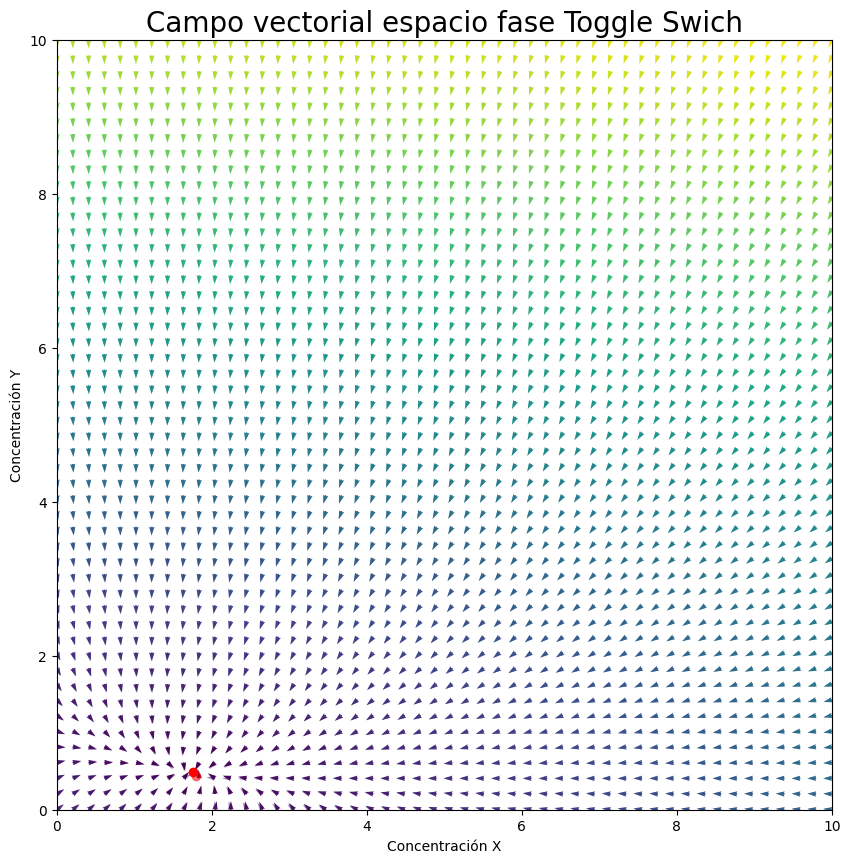

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))

# Primero graficamos la predicción, que debería ser más clara (alpha < 1)
Q = ax.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy', alpha=0.5)

# Luego, graficamos los datos originales, que serán más oscuros (alpha = 1)
Q1 = ax.quiver(Y1, Y2, u, v, M, angles='xy', alpha=1)

ax.scatter(x_valuespred, y_valuespred, color='red', alpha = 0.5)
ax.scatter(x_values, y_values, color='red', alpha = 1)
ax.set_title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

plt.show()

## Graficamos las diferencias

14.951750714775743


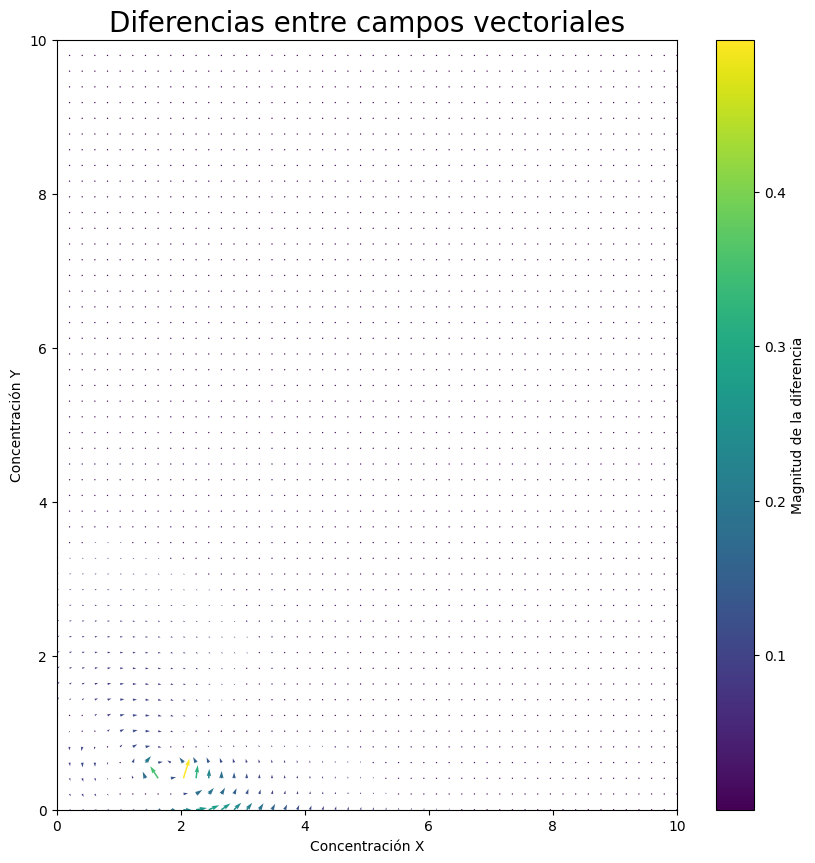

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Ahora calculamos la magnitud
#M_diff = np.hypot(u_diff2, v_diff2)
M_diff = np.hypot(u_diff, v_diff)

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30
print(rango)
# Escala para las flechas. Aumenta este valor si las flechas son demasiado grandes.

# Graficamos las diferencias
#Q = ax.quiver(Y1, Y2, u_diff2, v_diff2, M_diff, angles='xy')
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy', scale = rango)
#Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy')


ax.set_title('Diferencias entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia')

plt.show()

## Errores relativos

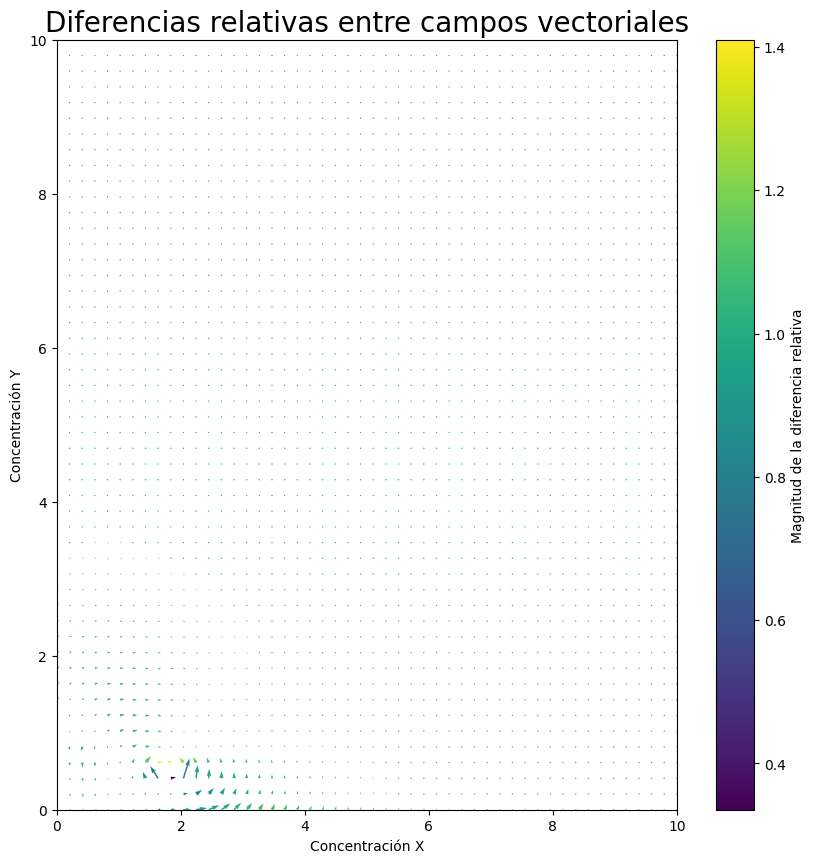

In [53]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7

# Calculamos la magnitud del vector original y de la diferencia
M_orig = np.hypot(u1, v1) + epsilon
M_diff = np.hypot(u1pred, v1pred)

# Calculamos la diferencia relativa
M_diff_rel = M_diff / M_orig

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30

# Graficamos las diferencias relativas
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff_rel, angles='xy', scale = rango)

ax.set_title('Diferencias relativas entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia relativa')

plt.show()

In [54]:
max_index_flattened = M_diff_rel.argmax()
max_coords = np.unravel_index(max_index_flattened, M_diff_rel.shape)
M_orig[max_coords]
print('El valor máximo de error relativo es de:', M_diff_rel.max() )
print('El valor de u1 en el error relativo máximo es:',u1[max_coords])
print('El valor de u1pred en el error relativo máximo es:',u1pred[max_coords])
print('El valor de v1 en el error relativo máximo es:',v1[max_coords])
print('El valor de v1pred en el error relativo máximo es:',v1pred[max_coords])

El valor máximo de error relativo es de: 1.4101709323988052
El valor de u1 en el error relativo máximo es: 0.19090674244381267
El valor de u1pred en el error relativo máximo es: 0.10616448942497314
El valor de v1 en el error relativo máximo es: -0.9908242366714131
El valor de v1pred en el error relativo máximo es: -1.4189644497726377
